<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_13_Autoencoders_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Denoising MNIST With Autoencoder

In [ ]:
# Import the small MNIST dataset that comes with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"),delimiter=",")

# Extract the labels and remove them from data
data = data[:,1:]

# Normalize data on range 0-1
dataNorm = data/np.max(data)

# Convert the data into tensor
dataT = torch.tensor(dataNorm).float()

In [ ]:
# Create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 250)

            # encoder layer
            self.enc = nn.Linear(250,50)

            # Latent Layer
            self.lat = nn.Linear(50,250)

            # Decoder Layer
            self.dec = nn.Linear(250,784)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x)) # data is normalized between 0-1, thus sigmoid
            return y

    # create model instance
    net = aenet()

    # Loss Function
    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [ ]:
# Test the model with a bit of data
net, lossfun, optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)
print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


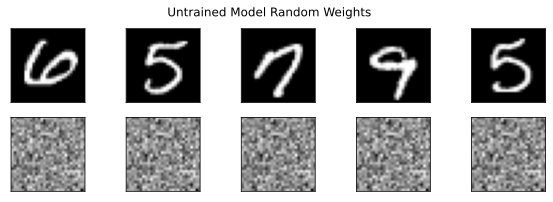

In [ ]:
# Plot and see
fig,axs = plt.subplots(2,5, figsize=(10,3))

for i in range(5):
    axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(yHat[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle("Untrained Model Random Weights")
plt.show()

In [ ]:
# Create a function to train the model
def function2trainTheModel():

    # Number of epochs
    numepochs = 10000

    # create new model instance
    net, lossfun, optimizer = createTheMNISTAE()

    losses = torch.zeros(numepochs)

    # Loop over the epochs
    for epochi in range(numepochs):

        # Select a random set of images: This is sort of minibatches, but bootstrapped
        randomidx = np.random.choice(dataT.shape[0], size=32)
        X = dataT[randomidx,:]

        # Forward Pass and Loss
        yHat = net(X)
        # Loss is difference of the whole data matrix
        loss = lossfun(yHat,X)

        # BackProp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Losses for each epoch
        losses[epochi] = loss.item()
    # End of epochs loop

    # The final output
    return losses, net

In [ ]:
# Train the model
losses, net = function2trainTheModel()
print(f"The final loss is: {losses[-1]:.4f}")

The final loss is: 0.0048


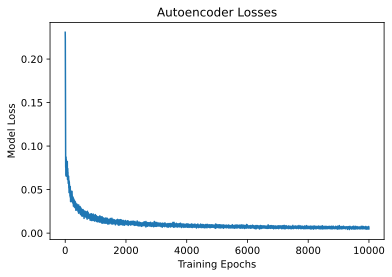

In [ ]:
# Visualize the losses
plt.plot(losses)
plt.xlabel("Training Epochs")
plt.ylabel("Model Loss")
plt.title("Autoencoder Losses")
plt.show()

In [ ]:
# Test the model with some data
X = dataT[:5,:]
yHat = net(X)

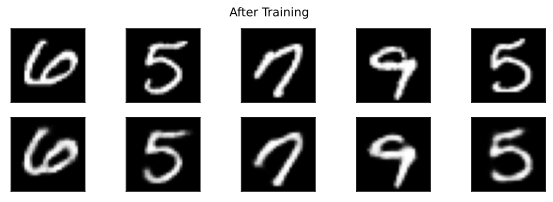

In [ ]:
# Plot and see
fig,axs = plt.subplots(2,5, figsize=(10,3))

for i in range(5):
    axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(yHat[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle("After Training")
plt.show()

## Autoencoders for Image Denoising

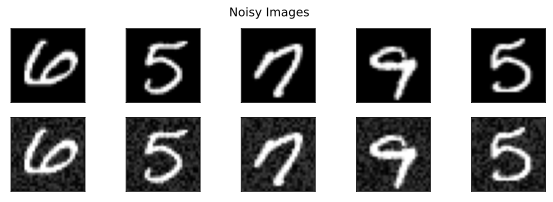

In [ ]:
# Grab a small set of images
X = dataT[:10,:]

# Add noise to them
Xnoise = X + torch.rand_like(X)/4

# clip at 1 to avoid pixcel values greater than 1
Xnoise[Xnoise > 1] = 1

# Show the Noisy images
fig,axs = plt.subplots(2,5, figsize=(10,3))

for i in range(5):
    axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(Xnoise[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle("Noisy Images")
plt.show()

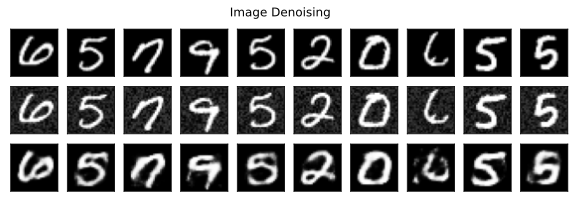

In [ ]:
# Run through the model and see what happens
Y = net(Xnoise)

fig,axs = plt.subplots(3,10, figsize=(10,3))

for i in range(10):
    axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(Xnoise[i,:].view(28,28).detach(), cmap="gray")
    axs[2,i].imshow(Y[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
    axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle("Image Denoising")
plt.show()

# Code Challange: How Many Units

Run parametric experiments to determine the necessary number of units in encoder/decoder and the bottleneck layer.

Parametrically manipulate the number of units in encoder/decoder from 10-500 in 12 linearly-spaced steps, and 5-100 units in 8 steps for the bottleneck units.

Store the average of the three final losses during training and show them in the form of a heatmap

Train on minibatches to sample the entire dataset without using dataloader objects and get a single-line progress report. Do not get 96 unique lines, get only a single line with the number of runs changing

In [ ]:
# Create a class for the model
def createTheMNISTAE(n_enc, n_bottle):

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, n_enc)

            # encoder layer
            self.enc = nn.Linear(n_enc,n_bottle)

            # Latent Layer
            self.lat = nn.Linear(n_bottle,n_enc)

            # Decoder Layer
            self.dec = nn.Linear(n_enc,784)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x)) # data is normalized between 0-1, thus sigmoid
            return y

    # create model instance
    net = aenet()

    # Loss Function
    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [ ]:
# Create a function to train the model
def function2trainTheModel(n_enc, n_bottle):

    # Number of epochs: experimental time
    numepochs = 3

    # create new model instance
    net, lossfun, optimizer = createTheMNISTAE(n_enc, n_bottle)

    losses = []

    # Batchsize and number of batches
    batchsize = 32
    numBatches = int(dataT.shape[0]/batchsize)

    # Loop over the epochs
    for epochi in range(numepochs):

        # get a permuted index vector
        randidx = np.random.permutation(dataT.shape[0]).astype(int)

        # Losses during the batches
        batchlosses = []

        # Loop over the batches
        for batchi in range(numBatches):

            # Samples to use in this batch
            samps2use = range((batchi-1)*batchsize, batchi*batchsize)

            # Select those images
            X = dataT[randidx[samps2use],:]

            # Forward Pass and Loss
            yHat = net(X)
            # Loss is difference of the whole data matrix
            loss = lossfun(yHat,X)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses for each epoch
            batchlosses.append(loss.item())
        # End of Minibatch loop

        losses.append(np.mean(batchlosses))
    # End of epochs loop

    # The final output
    return losses, net

In [ ]:
# Run the experiment
n_endec_units = np.linspace(10, 500, 12).astype(int)
n_bottle_units = np.linspace(5, 100, 8).astype(int)

# Initialize the results matrix
exp_results = np.zeros((len(n_endec_units), len(n_bottle_units)))

# loop over all possibilities
for ei, nenc in enumerate(n_endec_units):
    for bi, nbot in enumerate(n_bottle_units):

        # Train the model for each case
        losses = function2trainTheModel(nenc, nbot)[0] #Only the first output, ignore net
        exp_results[ei, bi] = np.mean(losses[-3:])

        # Print the updated message
        currentIter = ei*len(n_bottle_units) + bi + 1
        totalIters = len(n_bottle_units)*len(n_endec_units)
        msg = "Finished Experiment {}/{}".format(currentIter,totalIters)
        sys.stdout.write("\r" + msg)

Finished Experiment 96/96

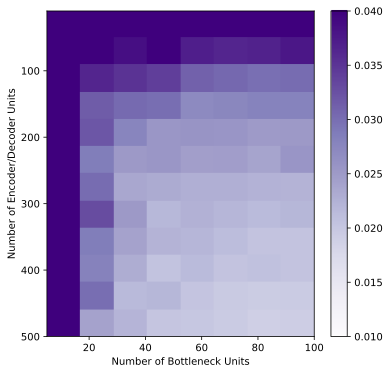

In [ ]:
# Plot the whole thing
fig = plt.figure(figsize=(6,6))

plt.imshow(exp_results, aspect="auto", vmin=0.01, vmax=0.04, cmap="Purples",
           extent=[n_bottle_units[0], n_bottle_units[-1], n_endec_units[-1], n_endec_units[0]])

plt.xlabel("Number of Bottleneck Units")
plt.ylabel("Number of Encoder/Decoder Units")
plt.colorbar()
plt.show()

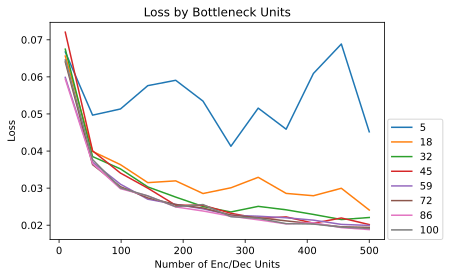

In [ ]:
# Use a line plot
plt.plot(n_endec_units, exp_results)
plt.legend(n_bottle_units, loc=(1.01,0))
plt.xlabel("Number of Enc/Dec Units")
plt.title("Loss by Bottleneck Units")
plt.ylabel("Loss")
plt.show()